<a href="https://colab.research.google.com/github/mixidota2/kaggle-indoor/blob/main/notebook/Indoor_001_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
- Baselineを構築するためのnotebook
- とりあえずデータ読んで最低限のsubをするだけを目的とする

In [ ]:
!nvidia-smi

Sat Mar 20 09:49:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
os.chmod(filename, 600)

Download 100%.
mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
os.chmod(filename, 600)

In [ ]:
!kaggle datasets download -d kokitanisaka/indoorunifiedwifids
!unzip indoorunifiedwifids.zip

 99% 457M/463M [00:19<00:00, 21.9MB/s]
100% 463M/463M [00:19<00:00, 24.5MB/s]
Archive:  indoorunifiedwifids.zip
  inflating: 5a0546857ecc773753327266_test.csv  
  inflating: 5a0546857ecc773753327266_train.csv  
  inflating: 5c3c44b80379370013e0fd2b_test.csv  
  inflating: 5c3c44b80379370013e0fd2b_train.csv  
  inflating: 5d27075f03f801723c2e360f_test.csv  
  inflating: 5d27075f03f801723c2e360f_train.csv  
  inflating: 5d27096c03f801723c31e5e0_test.csv  
  inflating: 5d27096c03f801723c31e5e0_train.csv  
  inflating: 5d27097f03f801723c320d97_test.csv  
  inflating: 5d27097f03f801723c320d97_train.csv  
  inflating: 5d27099f03f801723c32511d_test.csv  
  inflating: 5d27099f03f801723c32511d_train.csv  
  inflating: 5d2709a003f801723c3251bf_test.csv  
  inflating: 5d2709a003f801723c3251bf_train.csv  
  inflating: 5d2709b303f801723c327472_test.csv  
  inflating: 5d2709b303f801723c327472_train.csv  
  inflating: 5d2709bb03f801723c32852c_test.csv  
  inflating: 5d2709bb03f801723c32852c_train.csv

In [ ]:
import os
import glob 
import pickle
import random

import pandas as pd
import numpy as np

import yaml
from tqdm import tqdm
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt

import cv2

import scipy.stats as stats

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

tqdm.pandas(position=0, leave=True)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# consts
N_SPLITS = 10

SEED = 42

NUM_FEATS = 20

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
def get_timestamp():
    import time
    timestamp = ''
    for i, d in enumerate(time.localtime()):
        if i == 3:
            d += 8
        timestamp += str(d) + '-'
        if i == 4:
            break
    return timestamp[:-1]
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt((xhat-x)**2 + (yhat-y)**2) + 15 * np.abs(fhat-f)
#     intermediate = np.sqrt((xhat-x)**2 + (yhat-y)**2)
    return intermediate.sum()/xhat.shape[0]

## Preprocess

In [ ]:
with open(f'train_all.pkl', 'rb') as f:
  data = pickle.load( f)
with open(f'test_all.pkl', 'rb') as f:
  test_data = pickle.load(f)

In [ ]:
# count n features
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

In [ ]:
# get unique wifi bssids
wifi_bssids = []
for i in range(100):
    wifi_bssids.extend(data.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES: {wifi_bssids_size}')

wifi_bssids_test = []
for i in range(100):
    wifi_bssids_test.extend(test_data.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES: {wifi_bssids_size}')

wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)

BSSID TYPES: 61206
BSSID TYPES: 33042


In [ ]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(data['site_id'])

ss = StandardScaler()
ss.fit(data.loc[:,RSSI_FEATS])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
# apply transforms

data.loc[:,RSSI_FEATS] = ss.transform(data.loc[:,RSSI_FEATS])
for i in BSSID_FEATS:
    data.loc[:,i] = le.transform(data.loc[:,i])
    data.loc[:,i] = data.loc[:,i] + 1
    
data.loc[:, 'site_id'] = le_site.transform(data.loc[:, 'site_id'])

data.loc[:,RSSI_FEATS] = ss.transform(data.loc[:,RSSI_FEATS])

In [ ]:
test_data.loc[:,RSSI_FEATS] = ss.transform(test_data.loc[:,RSSI_FEATS])
for i in BSSID_FEATS:
    test_data.loc[:,i] = le.transform(test_data.loc[:,i])
    test_data.loc[:,i] = test_data.loc[:,i] + 1
    
test_data.loc[:, 'site_id'] = le_site.transform(test_data.loc[:, 'site_id'])

test_data.loc[:,RSSI_FEATS] = ss.transform(test_data.loc[:,RSSI_FEATS])

In [ ]:
site_count = len(data['site_id'].unique())
data.reset_index(drop=True, inplace=True)

In [ ]:
seed_everything(SEED)

## Some EDA

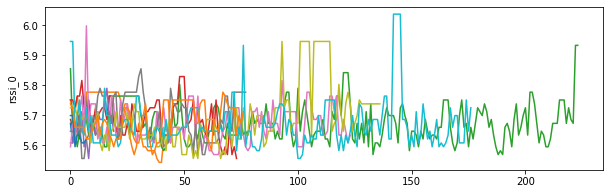

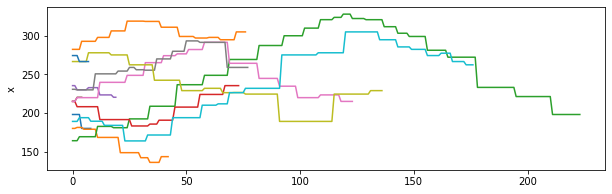

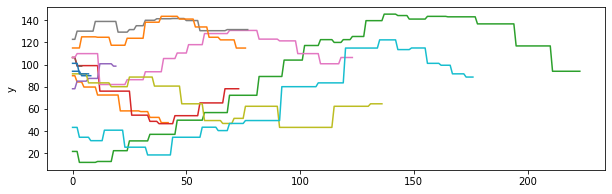

In [ ]:
plt.figure(figsize=(10,3))
max_iter = 10
for i, (name, group) in enumerate(data.groupby("path")):
    sns.lineplot(data=group, y=RSSI_FEATS[0], x=range(group.shape[0]))
    if i > max_iter:
        break
plt.figure(figsize=(10,3))
for i, (name, group) in enumerate(data.groupby("path")):
    sns.lineplot(data=group, y="x", x=range(group.shape[0]))
    if i > max_iter:
        break
plt.figure(figsize=(10,3))
for i, (name, group) in enumerate(data.groupby("path")):
    sns.lineplot(data=group, y="y", x=range(group.shape[0]))
    if i > max_iter:
        break

In [ ]:
tmp = data.loc[:,RSSI_FEATS]
tmp.head(10)

,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,rssi_9,rssi_10,rssi_11,rssi_12,rssi_13,rssi_14,rssi_15,rssi_16,rssi_17,rssi_18,rssi_19
0,5.841757,3.247589,2.577025,2.084538,1.833881,1.544942,1.388919,1.232740,1.118094,1.040804,0.975546,0.923306,0.883314,0.846874,0.820342,0.794867,0.769514,0.749619,0.728706,0.707716
1,5.880813,3.266062,2.577025,2.084538,1.833881,1.544942,1.388420,1.232740,1.118679,1.041533,0.976361,0.924179,0.883928,0.847415,0.820587,0.795088,0.769613,0.749710,0.728872,0.707791
2,5.828739,3.247589,2.574858,2.084538,1.832911,1.542993,1.387422,1.231619,1.117801,1.041047,0.975953,0.923830,0.883775,0.847145,0.820709,0.795199,0.769813,0.749892,0.729037,0.708014
3,5.659497,3.214339,2.572690,2.081890,1.830973,1.542993,1.387422,1.231245,1.117215,1.040561,0.975546,0.923480,0.883468,0.847009,0.820587,0.794978,0.769613,0.749710,0.728789,0.707791
4,5.711572,3.210645,2.568355,2.080566,1.830003,1.542343,1.387422,1.231619,1.117801,1.041047,0.975953,0.923655,0.883621,0.847009,0.820587,0.795088,0.769713,0.749801,0.728954,0.707940
5,5.659497,3.221728,2.579193,2.087186,1.835820,1.546242,1.388420,1.232740,1.118679,1.041776,0.976564,0.924179,0.883928,0.846874,0.820342,0.794867,0.769514,0.749619,0.728706,0.707716
6,5.672516,3.225422,2.581360,2.088510,1.836789,1.546892,1.387921,1.231993,1.117801,1.041047,0.975953,0.923830,0.883621,0.846874,0.820219,0.794756,0.769314,0.749436,0.728624,0.707642
7,5.659497,3.218033,2.577025,2.085862,1.834850,1.545592,1.388420,1.232740,1.118679,1.041533,0.976361,0.924179,0.883621,0.846738,0.820219,0.794646,0.769314,0.749436,0.728624,0.707642
8,5.659497,3.192172,2.557518,2.073946,1.826126,1.540394,1.385925,1.230497,1.116922,1.040318,0.975342,0.923131,0.883161,0.846738,0.820342,0.794867,0.769414,0.749436,0.728624,0.707642
9,5.659497,3.188478,2.559685,2.075270,1.827095,1.541044,1.386923,1.231245,1.116922,1.040318,0.975139,0.923131,0.883161,0.846738,0.820219,0.794756,0.769414,0.749527,0.728706,0.707716


## modeling

In [ ]:
class IndoorDataset(Dataset):
    def __init__(self, data, flag='TRAIN'):
        self.data = data
        self.flag = flag
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, index):
        tmp_data = self.data.iloc[index]
        if self.flag == 'TRAIN':
            return {
                'BSSID_FEATS':tmp_data[BSSID_FEATS].values.astype(float),
                'RSSI_FEATS':tmp_data[RSSI_FEATS].values.astype(float),
                'site_id':tmp_data['site_id'].astype(int),
                'x':tmp_data['x'],
                'y':tmp_data['y'],
                'floor':tmp_data['floor'],
            }
        else:
            return {
                'BSSID_FEATS':tmp_data[BSSID_FEATS].values.astype(float),
                'RSSI_FEATS':tmp_data[RSSI_FEATS].values.astype(float),
                'site_id':tmp_data['site_id'].astype(int)
            }

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, embedding_dim = 64, seq_len=20):
        super(simpleLSTM, self).__init__()
        self.emb_BSSID_FEATS = nn.Embedding(wifi_bssids_size, embedding_dim)
        self.emb_site_id = nn.Embedding(site_count, 2)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128, dropout=0.3, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16, dropout=0.1, bidirectional=False)
        self.lr = nn.Linear(NUM_FEATS, NUM_FEATS * embedding_dim)
        self.lr1 = nn.Linear(2562, 256)
        self.lr_xy = nn.Linear(16, 2)
        self.lr_floor = nn.Linear(16, 1)
        self.batch_norm1 = nn.BatchNorm1d(NUM_FEATS)
        self.batch_norm2 = nn.BatchNorm1d(2562)
        self.batch_norm3 = nn.BatchNorm1d(1)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        
        x_bssid = self.emb_BSSID_FEATS(x['BSSID_FEATS'])
        x_bssid = torch.flatten(x_bssid, start_dim=-2)
        
        x_site_id = self.emb_site_id(x['site_id'])
        x_site_id = torch.flatten(x_site_id, start_dim=-1)
        x_rssi = self.batch_norm1(x['RSSI_FEATS'])
        x_rssi = self.lr(x_rssi)
        x_rssi = torch.relu(x_rssi)
        
        x = torch.cat([x_bssid, x_site_id, x_rssi], dim=-1)
        x = self.batch_norm2(x)
        x = self.dropout(x)
        x = torch.relu(self.lr1(x))

        x = x.unsqueeze(-2)
        x = self.batch_norm3(x)
        x = x.transpose(0, 1)
        x, _ = self.lstm1(x)
        x = x.transpose(0, 1)
        x = torch.relu(x)
        x = x.transpose(0, 1)
        x, _ = self.lstm2(x)
        x = x.transpose(0, 1)
        x = torch.relu(x)
        xy = self.lr_xy(x)
        floor = self.lr_floor(x)
        floor = torch.relu(floor)
        return xy.squeeze(-2), floor.squeeze(-2)

In [ ]:
tmp = data.loc[:9,BSSID_FEATS]
tmp_ids = []
for i in range(20):
    tmp_ids.extend(tmp.iloc[:,i].values.tolist())
tmp_ids = len(list(set(tmp_ids)))
_emb = nn.Embedding(wifi_bssids_size, 64)
_res = _emb(torch.tensor(tmp.values.astype(float)).long())
_res = torch.flatten(_res, start_dim=-2)
#torch.tensor(tmp.values).size()

tmp2 = data.loc[:9,RSSI_FEATS]
tmp2_ids = []
for i in range(20):
    tmp2_ids.extend(tmp2.iloc[:,i].values.tolist())
tmp2_ids = len(list(set(tmp2_ids)))
lr = nn.Linear(20, 1280)
_res2 = lr(torch.tensor(tmp2.values.astype(float)).float())

tmp3 = data.loc[:9,"site_id"]
_emb2 = nn.Embedding(site_count, 2)
_res3 = _emb2(torch.tensor(tmp3.values.astype(float)).long())
_res3 = torch.flatten(_res3, start_dim=-1)

In [ ]:
_res.size(), _res2.size(), _res3.size()

(torch.Size([10, 1280]), torch.Size([10, 1280]), torch.Size([10, 2]))

In [ ]:
_all = torch.cat([_res, _res2, _res3], dim=-1)
_all = nn.Linear(2562, 256)(_all)

In [ ]:
_all.size()

torch.Size([10, 256])

In [ ]:
_un = _all.unsqueeze(-2)
_un.size()

torch.Size([10, 1, 256])

In [ ]:
_tr = _un.transpose(0, 1)
_tr.size()

torch.Size([1, 10, 256])

In [ ]:
_lstm1 = nn.LSTM(input_size=256,hidden_size=128, dropout=0.3, bidirectional=False)
_ls1, _ = _lstm1(_tr)
_ls1.size()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


torch.Size([1, 10, 128])

In [ ]:
_xy = _ls1.transpose(0, 1)
_xy = nn.Linear(128,2)(_xy)
_xy.size()

torch.Size([10, 1, 2])

In [ ]:
_xy.squeeze(-2).size()

torch.Size([10, 2])